{1: 'face', 2: 'hair', 3: 'eye', 4: 'eye'}
{'face': [253, 224, 201], 'hair': [130, 97, 103], 'eye': [6, 50, 85]}


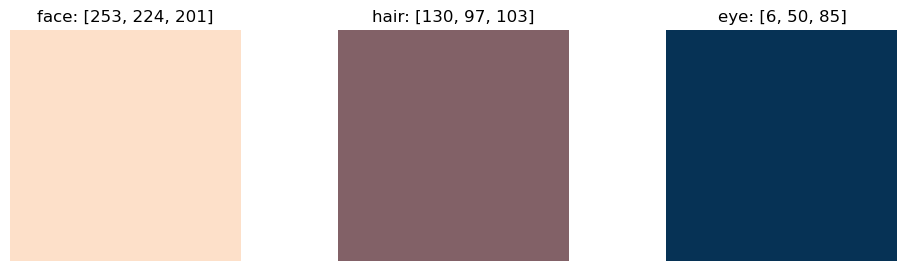

In [25]:
import os
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 讀取檔案並且返回結果的字典
directory = './output'
base_filename = 'segment'
result_dict = read_files_to_dict(directory, base_filename)

# 多檔案讀取並處理的函數
def read_files_to_dict(directory, base_filename, start_index=1):
    result_dict = {}
    index = start_index

    while True:
        file_path = os.path.join(directory, f"{base_filename}_{index}_output.txt")
        
        if not os.path.isfile(file_path):#找不到有這個名字的檔案時break
            break
        with open(file_path, 'r', encoding='utf-8') as file:
            first_line = file.readline().strip()#讀取檔案的第一行並去除兩側的空白自符
            first_line_split = first_line.split(':', 1)  # 只在第一次出現的':'進行分割
            result = first_line_split[1].strip() if len(first_line_split) > 1 else None #會得到的結果就是'1 face'
            
            # 進一步分割結果以獲得'face'
            final_result = result.split()[1] if result else None #以空格進行分割，取得分割後的第二個元素，如果result是空值就將final_result設為空值
            result_dict[index] = final_result  # 儲存進字典
            
        index += 1#處理下一個檔案
    return result_dict
# 多圖片讀取並處理的函數    
def load_images(directory, base_filename):
    image_files = []
    index = 1
    
    while True:
        file_path = os.path.join(directory, f"{base_filename}_{index}.png")
        
        if not os.path.isfile(file_path):
            break
        
        image_files.append(file_path)
        index += 1
    
    images = [Image.open(image_file) for image_file in image_files]
    
    return images

# 以k_means分析圖中佔比第二大的顏色(因為占比最大的顏色通常是背景，所以暫比第二大的顏色通常才是圖片的主要顏色)
def get_second_dominant_color(image, k=4):
    # Convert image to numpy array
    img_np = np.array(image)
    img_np = img_np.reshape((-1, 3))
    
    # Use KMeans 分析顏色
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(img_np)
    
    # 根據樣本點找到個顏色分布
    unique, counts = np.unique(kmeans.labels_, return_counts=True)
    sorted_indices = np.argsort(counts)
    
    # 找出 K-means 聚類算法中第二主要顏色的代表值(找出第二大的群集)
    second_dominant_color = kmeans.cluster_centers_[unique[sorted_indices[-2]]]
    
    return second_dominant_color.astype(int)

# 把第二主要顏色的色碼加入list中
second_dominant_colors = {str(i+1): get_second_dominant_color(img).tolist() for i, img in enumerate(images)}

# 合併兩個字典，以結果描述作為鍵，顏色碼作為值
combined_dict = {result_dict[key]: second_dominant_colors[str(key)] for key in result_dict}
print(result_dict)
print(combined_dict)

# 根據combined_dict元素數量顯示顏色預覽
fig, axs = plt.subplots(1, len(combined_dict), figsize=(12, 3))

# 遍歷字典中的每個元素
for ax, (title, color) in zip(axs, combined_dict.items()):
    # 將顏色轉換為 numpy 數組並進行歸一化
    color_array = np.array(color) / 255.0
    
    # 創建一個1x1的圖像顯示顏色
    ax.imshow([[color_array]])
    ax.set_title(f'{title}: {color}')
    ax.axis('off')

plt.show()
